# Installing external libraries

In [ ]:
!pip install PTable

  Created wheel for PTable: filename=PTable-0.9.2-cp37-none-any.whl size=22906 sha256=b1937cbb881c9083012889b88eced7e6d1ffe9585e6239baad4cd3472198e2c4
  Stored in directory: /root/.cache/pip/wheels/22/cc/2e/55980bfe86393df3e9896146a01f6802978d09d7ebcba5ea56
Successfully built PTable


In [ ]:
!pip install bigartm

     |████████████████████████████████| 1.9MB 6.5MB/s 


# Imports

In [ ]:
#basic package
import numpy as np
import pandas as pd
import scipy

#nlp
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import string
import gensim
from gensim import corpora, models
from gensim.models import Phrases, LsiModel, LdaModel
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary as GensimDict
from gensim.models.coherencemodel import CoherenceModel
import artm

#feature engineering
from gensim import utils
import gensim.parsing.preprocessing as gsp
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#vizualiazation
from pprint import pprint
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from prettytable import PrettyTable
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider, value, LabelSet, Legend, ColumnDataSource
from bokeh.plotting import figure, show, output_notebook, save

#settings
import os
import gc
import sys
import itertools
import shutil

import warnings 
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

#downloads
from google_drive_downloader import GoogleDriveDownloader as gdd

# Initiallization

In [ ]:
%matplotlib inline
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 12

output_notebook()

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

stopwords=nltk.corpus.stopwords.words('russian')
stopwords.extend(['что', 'это', 'так', 'вот', 'быть',
                   'как', 'на'])

# для воспроизводимости результатов
seed = 239
np.random.seed(seed)

# Auxilliary functions

In [ ]:
def doubles_and_nans(df, column_name):
    '''
    Функция для чистки текста. 
    df - таблица, над которой будет проводится чистка
    column_name - колонка, над которой будет проводится чистка
    '''
    doubles = list(df[df[column_name].duplicated() == True].index)
    df = df.drop(doubles, axis='index')
    df.reset_index(drop = True, inplace = True)

    not_str = []

    for i in range(len(df)):
      if type(df[column_name][i]) != str:
        not_str.append(i)
    df = df.drop(not_str, axis='index')
    df.reset_index(drop = True, inplace = True)

    return df

In [ ]:
def preprocessing(text):
    return ' '.join(text)

In [ ]:
def compute_coherence_values(model_name, dictionary, corpus, texts, limit, start=2, step=3):
        """
        Функция для вычисления c_v coherence для различных значений k
        Parameters:
        ----------
        dictionary : Gensim dictionary
        corpus : Gensim corpus
        texts : List of input texts
        limit : Max num of topics

        Returns:
        -------
        model_list : Список LDA topic models
        coherence_values : Coherence values corresponding to the LDA model with respective number of topics
        """
        
        def coherence_visual(coherence_values, limit, start, step):
            '''
            Функция для построения графика зависимости coherence_score от количества тем
            Parameters:
            ---------
            coherence_values : Coherence values corresponding to the LDA model with respective number of topics
            '''

            x = range(start, limit, step)
            plt.plot(x, coherence_values)
            plt.xlabel("Num Topics")
            plt.ylabel("Coherence score")
            plt.legend(("coherence_values"), loc='best')
            plt.show()    

            print(f'Coherence score of {model_name} for different k')
            for m, cv in zip(x, coherence_values):
                print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
                
        coherence_values = []
        model_list = []
        for num_topics in range(start, limit, step):

            if model_name == 'LDA':
                model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=2, workers=4)
            elif model_name == 'LSA':
                model = gensim.models.LsiModel(corpus, num_topics=num_topics, id2word=dictionary)

            model_list.append(model)
            coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())
        
        #построим coherence matrix и выведем основные значения coherence score
        coherence_visual(coherence_values, limit, start=2, step=3)
        
        return model_list, coherence_values

In [ ]:
def model_scores(model, model_name, list_of_scores):
        """
        Функция для вычисления текущих скоров     
        Parameters:
        ----------
        model: модель
        model_name : название модели
        list_of_scores: список названий скоров
        """
        plot = PrettyTable()

        plot.field_names = ["Name", "Method", 'Scores']

        for i in range(len(list_of_scores)):
            if list_of_scores[i] == 'TopicKernelScore':
                plot.add_row([model_name, list_of_scores[i], np.around(model.score_tracker[list_of_scores[i]].last_average_contrast, decimals = 5)])
                plot.add_row([model_name, list_of_scores[i], np.around(model.score_tracker[list_of_scores[i]].last_average_purity, decimals = 5)])
            else:
                plot.add_row([model_name, list_of_scores[i], np.around(model.score_tracker[list_of_scores[i]].last_value, decimals = 5)])

        print(plot)

In [ ]:
def model_evaluation(model, model_name, texts, topics, dictionary):
        """
        Функция для вычисления UCI и UMass      
        Parameters:
        ----------
        model: название модели
        texts : список текстов
        dictionary : Gensim словарь
        """
        def convert_words_to_tokens(dictionary, list_of_topics):
            """
            Функция для вычисления UCI и UMass      
            Parameters:
            ----------
            model: название модели
            texts : список текстов
            dictionary : Gensim словарь
            Returns:
            ----------

            """
            topics = []
            for topic in list_of_topics:
                topic_list = []
                for word in topic:
                     if word in dictionary.values():
                         topic_list.append(list(dictionary.values()).index(word))
                topics.append(topic_list)
            return topics

        plot = PrettyTable()

        plot.field_names = ["Name", "Method", " Coherence score"]
        
        if (model_name == 'LSA') or (model_name == 'LDA'):
            plot.add_row([model_name, 'uci', np.around(CoherenceModel(model=model, texts=texts, dictionary=dictionary, 
                                                                      coherence='c_uci').get_coherence(), decimals = 3)])
            plot.add_row([model_name, 'u_mass', np.around(CoherenceModel(model=model, texts=texts, dictionary=dictionary, 
                                                                         coherence='u_mass').get_coherence(), decimals = 3)])
        elif (model_name == 'ARTM'):
            plot.add_row([model_name, 'uci', np.around(CoherenceModel(topics=convert_words_to_tokens(dictionary, topics), 
                                                                      texts=texts, dictionary=dictionary, 
                                                                      coherence='c_uci').get_coherence(), decimals = 3)])
            plot.add_row([model_name, 'u_mass', np.around(CoherenceModel(topics=convert_words_to_tokens(dictionary, topics), 
                                                                         texts=texts, dictionary=dictionary, 
                                                                         coherence='u_mass').get_coherence(), decimals = 3)])

        print(plot)

In [ ]:
def tsne_vis(model, model_name):
        """
        Функция для визуализации распределения документов по темам
        Parameters:
        ----------
        model: модель
        model_name: название модели
        """
        tsne_model = TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=0)
        tsne_data = tsne_model.fit_transform(model.get_theta().T)

        topic_num = np.argmax(model.get_theta().T.values, axis=1)
        topic_num = pd.DataFrame(data=topic_num, columns=['topic'])
        
        tsne_data = pd.DataFrame(data=tsne_data, columns=['x', 'y'])
        tsne_data = pd.concat([tsne_data, topic_num], axis = 1)

        plt.figure(figsize=(15,15))
        sns.scatterplot(x="x", y="y", hue='topic', palette="Set1", data=tsne_data).set(xlabel='x_1', ylabel='x_2', title=f'TSNE visualization for {model_name} model: {num_of_topics} topics')
        plt.legend(title='topics:', loc='upper right');

# EDA

В прошлой версии были некоторые недочеты при препроцессинге. В этой они исправлены.

[Новое EDA тут](https://colab.research.google.com/drive/1EbW11W0aaffajAYUWu-LhVBk13S4i6vI)

# Download preprocessed text & prepare it

In [ ]:
gdd.download_file_from_google_drive(file_id='1enPF5DzavjgLARMArqZr3pnesrvNAg5H',\
                                    dest_path='/HW/h2w.prepro_1.csv')
df = pd.read_csv('/HW/h2w.prepro_1.csv', sep=',')

In [ ]:
df = df[['clean_text', 'clean_tags', 'clean_hubs']]
df.head(5)

,clean_text,clean_tags,clean_hubs
0,следующий год год момент создание служба катал...,"['microsoft', 'облако', 'azure', 'event', 'sec...","['информационная_безопасность', 'системное_адм..."
1,sdk magic leap скорокомпания magic leap волшеб...,"['apple', 'magic_leap', 'fluent']","['разработка_мобильных_приложений', 'разработк..."
2,публиковать перевод статья который наслать hac...,"['программирование', 'парное_программирование'...","['программирование', 'git', 'системы_управлени..."
3,будущее электронный торговля здесьпрежде перех...,"['автоматизация_торговли', 'электронная_торгов...","['управление_e-commerce', 'периферия']"
4,рамка дать статья постараться дать ответ вопро...,"['bitcoin', 'privacy', 'bitshares', 'monero']","['информационная_безопасность', 'платежные_сис..."


In [ ]:
df.shape

(43851, 3)

In [ ]:
df = doubles_and_nans(df, 'clean_text')

In [ ]:
df.shape

(43850, 3)

In [ ]:
%%time

df['clean_tags'] = df['clean_tags'].apply(lambda row: eval(row))
df['clean_hubs'] = df['clean_hubs'].apply(lambda row: eval(row))

CPU times: user 1.05 s, sys: 42.5 ms, total: 1.09 s
Wall time: 1.09 s


In [ ]:
df.head(5)

,clean_text,clean_tags,clean_hubs
0,следующий год год момент создание служба катал...,"[microsoft, облако, azure, event, security, ac...","[информационная_безопасность, системное_админи..."
1,sdk magic leap скорокомпания magic leap волшеб...,"[apple, magic_leap, fluent]","[разработка_мобильных_приложений, разработка_игр]"
2,публиковать перевод статья который наслать hac...,"[программирование, парное_программирование, gi...","[программирование, git, системы_управления_вер..."
3,будущее электронный торговля здесьпрежде перех...,"[автоматизация_торговли, электронная_торговля]","[управление_e-commerce, периферия]"
4,рамка дать статья постараться дать ответ вопро...,"[bitcoin, privacy, bitshares, monero]","[информационная_безопасность, платежные_систем..."


In [ ]:
df = df[:20000]

# LSA & LDA 

[Старая версия домашки, но на нормально обработанных данных](https://colab.research.google.com/drive/193MBEQdH-gNYyjoUnDc9U5plbA74FYKJ#scrollTo=Bu1dECb-xSWP)

# BigARTM

При выполнении работы ориентировались на следующие публикации:

*   [Апишев Мурат. BigARTM. Руководство для пользователей Python API](https://github.com/bigartm/bigartm-book/blob/master/ARTM_tutorial_RU.ipynb)
*   [Апишев Мурат. Модельный эксперимент с использованием BigARTM Python API](https://github.com/bigartm/bigartm-book/blob/master/ARTM_example_RU.ipynb)



Оглядываясь назад, становится очевидно, что логичнее было бы и предыдущую часть дз делать с помощью BigARTM. Был бы общий интерфейс для вообще всех моделей (если LSA заменить на pLSA).

Но это не было сделано. Поэтому для artm будет немного свое "воплощение". 

## Словари и батчи

BigARTM работает с данными в определенных форматах. И перед началом работы нам необходимо наши данные подготовить.

Необходимо получить следующие объекты:

1. директория, в которой будут батчи и словарь в бинарном файле dictionary.dict
2. переменная-словарь dictionary, в которой этот самый словарь есть (собран или загружен).
3. переменная batch_vectorizer

Для начала необходимо получить переменную n_wd типа numpy.ndarray размера "число уникальных слова в коллекции" на "число документов", содержащую счётчики $n_{wd}$ (т. е. матрицу "мешка слов") и Python dict vocabulary в котором ключом является индекс строки этой матрицы, а значением - исходное слово. Получить такие переменные при наличии сырых текстов проще всего с использованием CountVectorizer из sklearn.

In [ ]:
%%time

cv = CountVectorizer(max_features=1000)
n_wd = np.array(cv.fit_transform(df['clean_text'].values.astype('U')).todense()).T  #  типа numpy.ndarray размера "число уникальных слова в коллекции" на "число документов", содержащую счётчики  nwd  (т. е. матрицу "мешка слов")
vocabulary = cv.get_feature_names() # список первых 1000 слов с наибольшей встречаемостью

CPU times: user 40.2 s, sys: 7.96 s, total: 48.1 s
Wall time: 48.1 s


In [ ]:
target_folder = 'data_dict' #задаем директорию

In [ ]:
%%time

batch_vectorizer = artm.BatchVectorizer(data_format='bow_n_wd',
                                        n_wd=n_wd,
                                        target_folder=target_folder,
                                        vocabulary=vocabulary)

CPU times: user 44.9 s, sys: 216 ms, total: 45.2 s
Wall time: 45.3 s


Следующая цель после создания батчей - создание словаря. Соберем словарь по директории с батчами. 

In [ ]:
dictionary = artm.Dictionary()

In [ ]:
if not os.path.isfile(target_folder + '/dictionary.dict'):
    dictionary.gather(data_path=batch_vectorizer.data_path) #собрали
    dictionary.save(dictionary_path=target_folder + '/dictionary.dict') #сохранили

dictionary.load(dictionary_path=target_folder + '/dictionary.dict') #загрузили

В таком варианте слова в словаре (и в дальнейшей матрице $\Phi$) будут идти в случайном порядке.

## Обучение модели

In [ ]:
num_of_topics = 5

In [ ]:
artm_model = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(num_of_topics)],
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)],
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15)],
                       cache_theta = True)

Была создана матрица $\Phi$ размером "число слов словаря" на число тем, инициализированная случайным образом. 

Матрица тета - документы на топики. Нам нужна будет эта матрицадля TSNE. Поэтому хранить ее будем. Поэтому cache_theta = True

In [ ]:
artm_model.initialize(dictionary=dictionary)

Теперь перейдём к главному действию - обучению модели. Сделать это можно одним из двух способов: онлайновым или оффлайновым. 

Оффлайновый алгоритм: много проходов по коллекции, один проход по документу (опционально), обновление Φ в конце каждого прохода. 

Онлайновый алгоритм - слишком сложен

In [ ]:
artm_model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'), overwrite=True)
artm_model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'), overwrite=True)
artm_model.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3), overwrite=True)
artm_model.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))

In [ ]:
artm_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1), overwrite=True)
artm_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5), overwrite=True)

In [ ]:
artm_model.num_document_passes = 1

In [ ]:
%%time

artm_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

CPU times: user 38.7 s, sys: 371 ms, total: 39.1 s
Wall time: 10.2 s


Посмотрим, а что мы получили:

In [ ]:
model_scores(artm_model, 'ARTM', ['PerplexityScore', 'SparsityPhiScore', 'SparsityThetaScore', 'TopicKernelScore'])

+------+--------------------+----------+
| Name |       Method       |  Scores  |
+------+--------------------+----------+
| ARTM |  PerplexityScore   | 695.7207 |
| ARTM |  SparsityPhiScore  |  0.0006  |
| ARTM | SparsityThetaScore |  5e-05   |
| ARTM |  TopicKernelScore  | 0.38473  |
| ARTM |  TopicKernelScore  | 0.39184  |
+------+--------------------+----------+


In [ ]:
artm_model.score_tracker['PerplexityScore'].value

[997.0225219726562,
 698.123046875,
 697.9451904296875,
 697.7676391601562,
 697.5630493164062,
 697.3250122070312,
 697.0413208007812,
 696.694580078125,
 696.2628173828125,
 695.720703125]

Поучим еще. 

In [ ]:
%%time

artm_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

CPU times: user 39 s, sys: 313 ms, total: 39.3 s
Wall time: 10.2 s


И еще раз

In [ ]:
model_scores(artm_model, 'ARTM', ['PerplexityScore', 'SparsityPhiScore', 'SparsityThetaScore', 'TopicKernelScore'])

+------+--------------------+-----------+
| Name |       Method       |   Scores  |
+------+--------------------+-----------+
| ARTM |  PerplexityScore   | 679.71869 |
| ARTM |  SparsityPhiScore  |   0.0024  |
| ARTM | SparsityThetaScore |  0.00077  |
| ARTM |  TopicKernelScore  |  0.44434  |
| ARTM |  TopicKernelScore  |  0.47884  |
+------+--------------------+-----------+


In [ ]:
artm_model.score_tracker['PerplexityScore'].value

[997.0225219726562,
 698.123046875,
 697.9451904296875,
 697.7676391601562,
 697.5630493164062,
 697.3250122070312,
 697.0413208007812,
 696.694580078125,
 696.2628173828125,
 695.720703125,
 695.0390014648438,
 694.18798828125,
 693.1382446289062,
 691.8685302734375,
 690.3656005859375,
 688.6276245117188,
 686.6666870117188,
 684.5050659179688,
 682.1751098632812,
 679.7186889648438]

In [ ]:
artm_model.get_phi()

,topic_0,topic_1,topic_2,topic_3,topic_4
слой,0.000830,0.001117,0.000471,0.000112,0.000288
контейнер,0.000597,0.000382,0.000052,0.000108,0.001247
вектор,0.000254,0.000751,0.000174,0.000097,0.000501
смартфон,0.000109,0.001283,0.000591,0.000337,0.000526
цифровой,0.000085,0.001013,0.001038,0.000166,0.000093
...,...,...,...,...,...
предложить,0.000240,0.000160,0.001025,0.000908,0.000161
публикация,0.000021,0.000393,0.000349,0.000301,0.001114
связать,0.000841,0.000422,0.001098,0.000135,0.000482
итог,0.000576,0.000218,0.001688,0.001192,0.000760


In [ ]:
artm_model.get_theta().T

,topic_0,topic_1,topic_2,topic_3,topic_4
3000,0.144836,0.203606,0.253812,0.217028,0.180718
3001,0.255414,0.202814,0.134306,0.218078,0.189388
3002,0.127107,0.211604,0.201869,0.226419,0.233000
3003,0.146013,0.199250,0.242730,0.222843,0.189165
3004,0.203239,0.201833,0.194404,0.204799,0.195725
...,...,...,...,...,...
5995,0.157603,0.190896,0.228160,0.225041,0.198299
5996,0.173637,0.184448,0.158873,0.262784,0.220258
5997,0.172594,0.202998,0.205996,0.216086,0.202326
5998,0.141974,0.234545,0.236244,0.187450,0.199787


In [ ]:
artm_model_topics = []
for topic_name in artm_model.topic_names:
    print('{0}: {1}'.format(topic_name, artm_model.score_tracker['TopTokensScore'].last_tokens[topic_name]))
    artm_model_topics.append(artm_model.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: ['данные', 'использовать', 'значение', 'файл', 'метод', 'функция', 'return', 'тип', 'объект', 'работа']
topic_1: ['год', 'очень', 'работать', 'быть', 'работа', 'свой', 'использовать', 'просто', 'уровень', 'хотеть']
topic_2: ['который', 'человек', 'свой', 'такой', 'время', 'мочь', 'делать', 'один', 'каждый', 'вопрос']
topic_3: ['который', 'система', 'новый', 'технология', 'такой', 'решение', 'год', 'компания', 'каждый', 'первый']
topic_4: ['который', 'время', 'пользователь', 'код', 'случай', 'наш', 'использовать', 'получить', 'задача', 'несколько']


## Coherence scores

In [ ]:
texts = []
for index, row in df[['clean_text']].iterrows():
    texts.append(row['clean_text'].split())

In [ ]:
gen_dictionary = GensimDict(texts)
corpus = [gen_dictionary.doc2bow(doc) for doc in texts]

In [ ]:
model_evaluation(artm_model, 'ARTM', texts, artm_model_topics, gen_dictionary)

+------+--------+------------------+
| Name | Method |  Coherence score |
+------+--------+------------------+
| ARTM |  uci   |      0.051       |
| ARTM | u_mass |      -0.576      |
+------+--------+------------------+


## Vizualization

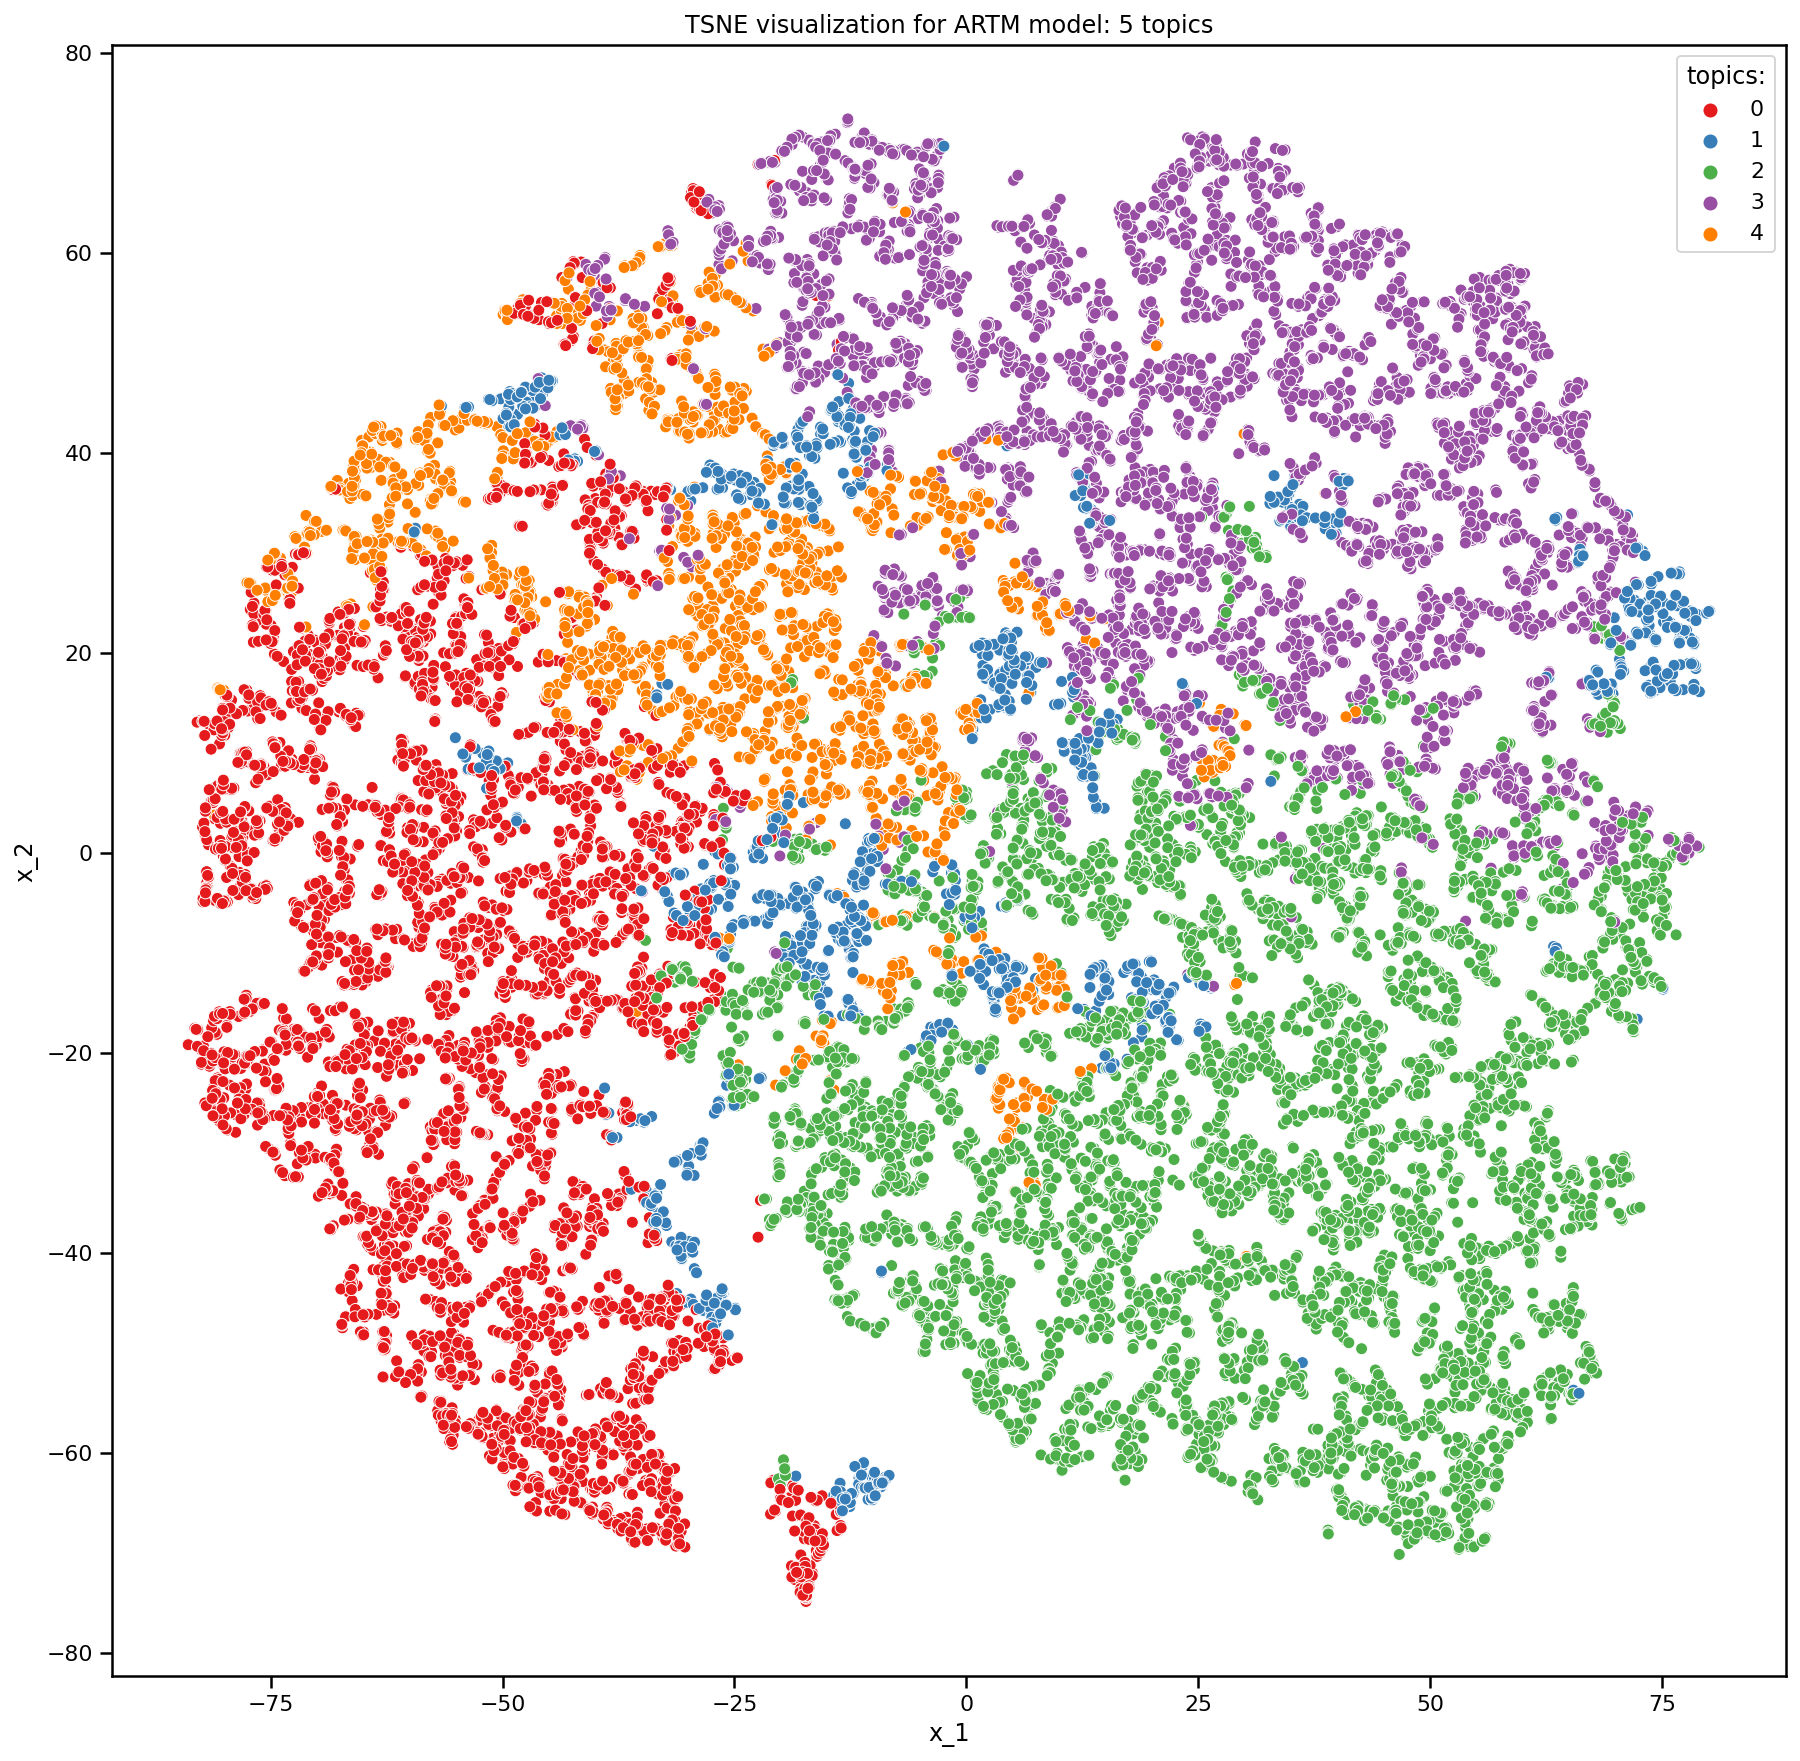

In [ ]:
tsne_vis(artm_model, 'ARTM')